In [103]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import interpolate
from scipy import integrate
from scipy import optimize
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from math import sqrt

In [158]:
#radiation constant in GJ/keV^4/cm^3
a = 0.01372
#speed of light in cm/sh; 1 sh is 10^-8 s
c = 299.98
Planck_int_const = 15*a*c/(4*math.pi**5)


def RHS(Tvect,t,Nx,dx,sigma1,chi1,sigma2,chi2,Cve,invEOS,Q1,Q2,Tl,f):
    E1 = Tvect[0:Nx]
    E2 = Tvect[Nx:(2*Nx)]
    Te = Tvect[2*Nx:]*0
    E = Tvect[2*Nx:]
    
    idx2 = 1.0/dx/dx
    xs = np.linspace(dx/2,Nx*dx-dx/2,Nx)
    E1new = E1*0
    E2new = E1*0
    Enew = Te*0
    
    #compute T
    for i in range(Nx):
        Te[i] = invEOS(t,E[i])
    
    for i in range(Nx):
            
        chi1_eval = chi1(t,Te[i])
        chi2_eval = chi2(t,Te[i])
        f_eval = f(Te[i])
        if (i>0) and (i<Nx-1):
            kappa1_l = sigma1(t,(Te[i-1]+Te[i])*0.5)
            kappa1_r = sigma1(t,(Te[i+1]+Te[i])*0.5)
            kappa2_l = sigma2(t,(Te[i-1]+Te[i])*0.5)
            kappa2_r = sigma2(t,(Te[i+1]+Te[i])*0.5)
            #we assume that the form of the opacity is the same
            #so we do not need to do the harmonic mean trick
            D1_l = c/(3.0*kappa1_l)
            D1_r = c/(3.0*kappa1_r)
            D2_l = c/(3.0*kappa2_l)
            D2_r = c/(3.0*kappa2_r)
            
            E1new[i] = (D1_r*idx2*(E1[i+1]-E1[i]) - D1_l*idx2*(E1[i]-E1[i-1]) - 
                         c*sigma1(t,Te[i])*E1[i] + a*c*Te[i]**4*chi1_eval*f_eval + Q1(t,xs[i],Te[i]))
            E2new[i] = (D2_r*idx2*(E2[i+1]-E2[i]) - D2_l*idx2*(E2[i]-E2[i-1]) - 
                         c*sigma2(t,Te[i])*E2[i] + a*c*Te[i]**4*chi2_eval*(1-f_eval) + Q2(t,xs[i],Te[i]))
            
        elif (i==0):
            kappa1_l = sigma1(t,(Tl+Te[i])*0.5)
            kappa1_r = sigma1(t,(Te[i+1]+Te[i])*0.5)
            kappa2_l = sigma2(t,(Tl+Te[i])*0.5)
            kappa2_r = sigma2(t,(Te[i+1]+Te[i])*0.5)
            #we assume that the form of the opacity is the same
            #so we do not need to do the harmonic mean trick
            D1_l = c/(3.0*kappa1_l)
            D1_r = c/(3.0*kappa1_r)
            D2_l = c/(3.0*kappa2_l)
            D2_r = c/(3.0*kappa2_r)
            
            E1new[i] = (D1_r*idx2*(E1[i+1]-E1[i]) - D1_l*idx2*(E1[i]-a*Tl**4*f_eval) - 
                         c*sigma1(t,Te[i])*E1[i] + a*c*Te[i]**4*chi1_eval*f_eval + Q1(t,xs[i],Te[i]))
            E2new[i] = (D2_r*idx2*(E2[i+1]-E2[i]) - D2_l*idx2*(E2[i]-a*Te[i]**4*(1-f_eval)) - 
                         c*sigma2(t,Te[i])*E2[i] + a*c*Te[i]**4*chi2_eval*(1-f_eval) + Q2(t,xs[i],Te[i]))
            
        elif (i==Nx-1):
            
            #Reflecting boundary so that the derivative goes to zero
            kappa1_l = sigma1(t,(Te[i-1]+Te[i])*0.5)
            kappa2_l = sigma2(t,(Te[i-1]+Te[i])*0.5)
            #we assume that the form of the opacity is the same
            #so we do not need to do the harmonic mean trick
            D1_l = c/(3.0*kappa1_l)
            D2_l = c/(3.0*kappa2_l)
            
            E1new[i] = (0 - D1_l*idx2*(E1[i]-E1[i-1]) - 
                         c*sigma1(t,Te[i])*E1[i] + a*c*Te[i]**4*chi1_eval*f_eval + Q1(t,xs[i],Te[i]))
            E2new[i] = (0 - D2_l*idx2*(E2[i]-E2[i-1]) - 
                         c*sigma2(t,Te[i])*E2[i] + a*c*Te[i]**4*chi2_eval*(1-f_eval) + Q2(t,xs[i],Te[i]))
        Enew[i] =  (c*sigma1(t,Te[i])*E1[i] + c*sigma2(t,Te[i])*E2[i] - 
                                      a*c*Te[i]**4*chi2_eval*(1-f_eval) - a*c*Te[i]**4*chi1_eval*f_eval)

    Tfinal = np.zeros(Nx*3)
    Tfinal[0:Nx] = E1new.copy()
    Tfinal[Nx:(2*Nx)] = E2new.copy()
    Tfinal[(2*Nx):] = Enew.copy()
    return Tfinal

In [159]:

def f(T,nu0):
    r = nu0/T
    r3 = r**3
    r2 = r**2
    res = 0
    for n in range(1,7):
        a0 = 1/n
        a1 = 3/n**2
        a2 = 6/n**3
        a3 = 6/n**4
        res += (a0*r3 + a1*r2 + a2*r + a3 ) * math.exp(-n*r)
    return 1-15/math.pi**4 * res

In [115]:
#set up initial conditions
Lx = 4.0
Nx = 100
dx = Lx/Nx
xval = np.linspace(dx/2,Lx-dx/2,Nx)

nu0 = 10.0
fT = lambda T: f(T,nu0)

sigma1 = lambda t, Te: 1.0
sigma2 = lambda t, Te: 1.0e-9
chi1 = lambda t, Te: 1.0
chi2 = lambda t, Te: 1.0e-9
Q1 = lambda t, x, Te: 1.0*(x>=(Lx-0.5))
Q2 = lambda t, x, Te: 0.0
Cve = lambda t,Te: 4*a*Te**3
invEOS = lambda t,E: (E/a)**.25
Tl = 0.0
RHS_lam = lambda t,Tvect: RHS(Tvect,t,Nx,dx,sigma1,chi1,sigma2,chi2,Cve,invEOS,Q1,Q2,Tl,fT)


Te_init = np.zeros(Nx) + 1e-3
Tfull_init = np.zeros(Nx*3)
Tfull_init[0:Nx] = Te_init**4 * a*fT(Te_init[0])
Tfull_init[Nx:2*Nx] = Te_init**4 * a*c*(1-fT(Te_init[0]))
Tfull_init[2*Nx:] = Cve(0,1e-3)*Te_init

In [95]:
sol = integrate.solve_ivp(RHS_lam, (0,1/c), Tfull_init, 
                                         method='BDF', max_step = 1e-3)

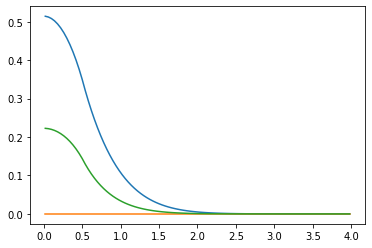

In [102]:

plt.plot(Lx-xval,(sol.y[0:Nx,-1])*c)
plt.plot(Lx-xval,sol.y[Nx:2*Nx,-1]*c)
plt.plot(Lx-xval,sol.y[Nx*2:,-1]*c)

In [162]:
#set up initial conditions
Lx = 5.0
Nx = 100
dx = Lx/Nx
xval = np.linspace(dx/2,Lx-dx/2,Nx)

nu0 = 0.5
fT = lambda T: f(T,nu0)

sigma1 = lambda t, Te: 1.0
sigma2 = lambda t, Te: 1.0/3.0
chi1 = lambda t, Te: 0.75
chi2 = lambda t, Te: 0.25*fT(Te)/(1-fT(Te)+1e-12)
Q1 = lambda t, x, Te: 1.0*(x>=(Lx-0.5))
Q2 = lambda t, x, Te: 0.0
delta = 1e-4
Cve = lambda t,Te: (fT(Te+delta)*a*(Te+delta)**4-fT(Te)*a*Te**4)/delta
EOS = lambda t,T: fT(T)*a*T**4
invEOS = lambda t,E: optimize.brentq(lambda Ts: EOS(t,Ts)-E, 1e-10, 100,disp=True) 
Tl = 0.0
RHS_lam = lambda t,Tvect: RHS(Tvect,t,Nx,dx,sigma1,chi1,sigma2,chi2,Cve,invEOS,Q1,Q2,Tl,fT)


Te_init = np.zeros(Nx) + 1e-3
Tfull_init = np.zeros(Nx*3)
Tfull_init[0:Nx] = Te_init**4 * a*fT(Te_init[0])
Tfull_init[Nx:2*Nx] = Te_init**4 * a*c*(1-fT(Te_init[0]))
Tfull_init[2*Nx:] = Cve(0,1e-3)*Te_init

In [163]:
sol = integrate.solve_ivp(RHS_lam, (0,5/c), Tfull_init, 
                                         method='BDF', max_step = 1e-3)

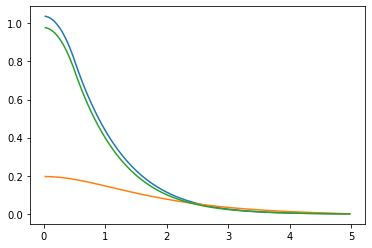

In [166]:

plt.plot(Lx-xval,(sol.y[0:Nx,-1])*c)
plt.plot(Lx-xval,sol.y[Nx:2*Nx,-1]*c)
plt.plot(Lx-xval,sol.y[Nx*2:,-1]*c)

In [129]:
print(fT(1e-6))

1.0
